<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S15/Final_Combined(128%2C128)_400k_Train_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
import torch
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [0]:
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Dataset')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Dataset')

In [0]:
import mymodel as md
device='cuda'
model=md.Unet().to(device)

In [7]:
!pip install torchsummary
from summ import summ as sm
from Keiming import weight as km
device=sm.model_gpuchk()
model.apply(km.weights_init)
sm.summ_print(model,input=[(3,128,128),(3,128,128)])

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4         [-1, 64, 128, 128]          20,160
              ReLU-5         [-1, 64, 128, 128]               0
       BatchNorm2d-6         [-1, 64, 128, 128]             128
            Conv2d-7        [-1, 128, 128, 128]         114,048
              ReLU-8        [-1, 128, 128, 128]               0
       BatchNorm2d-9        [-1, 128, 128, 128]             256
           Conv2d-10        [-1, 256, 128, 128]         523,008
             ReLU-11        [-1, 256, 128, 128]               0
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13         [-1, 64, 128, 128]         147,456
             ReLU-14         [-1, 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [0]:
rm -r '/content/data/'

rm: cannot remove '/content/data/': No such file or directory


In [8]:
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z' -o'/content/data/bg/'
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/fgbg.7z' -o'/content/data/fgbg/'
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/fgbgmask.7z' -o'/content/data/fgbgmask/'
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/Densedepth.7z' -o'/content/data/densedepth/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Colab Notebooks/Dataset/                                                           1 file, 2286969 bytes (2234 KiB)

Extracting archive: /content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z
--
Path = /content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z
Type = 7z
Physical Size = 2286969
Headers Size = 1341
Method = LZMA2:3m
Solid = +
Blocks = 1

  0%     45%    Everything is Ok

Files: 100
Size:       2341905
Compressed: 2286969

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) C

In [0]:
from fetch_list import getlist as gt
bg_image_list_final,fgbg_image_list,mask_image_list,depth_image_list=gt.list()

In [10]:
fgbg_image_dataset=sorted(fgbg_image_list)
bg_image_dataset=sorted(bg_image_list_final)
mask_image_dataset=sorted(mask_image_list)
depth_image_dataset=sorted(depth_image_list)
print('No of data in fgbg list:',   len(fgbg_image_dataset))
print('No of data in bg list:' ,    len(bg_image_dataset))
print('No of image in mask image:', len(mask_image_dataset))
print('No of image in depth image:', len(depth_image_dataset))

No of data in fgbg list: 400000
No of data in bg list: 400000
No of image in mask image: 400000
No of image in depth image: 400000


In [0]:
#Training 150k to 200k
fgbg_image_dataset=fgbg_image_list[350000:400000]
bg_image_dataset=bg_image_list_final[350000:400000]
mask_image_dataset=mask_image_list[350000:400000]
depth_image_dataset=depth_image_list[350000:400000]
print('No of data in fgbg list:',   len(fgbg_image_dataset))
print('No of data in bg list:' ,    len(bg_image_dataset))
print('No of image in mask image:', len(mask_image_dataset))
print('No of image in depth image:', len(depth_image_dataset))

No of data in fgbg list: 50000
No of data in bg list: 50000
No of image in mask image: 50000
No of image in depth image: 50000


In [0]:
from transform import transform as t
from transform import Myclass
fgbg_transform,bg_transform,mask_transform,depth_transform=t.trans()

In [0]:
import glob
from PIL import Image
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [13]:
final_dataset=Myclass(bg_image_dataset,fgbg_image_dataset,mask_image_dataset,depth_image_dataset,transform=[fgbg_transform,bg_transform,mask_transform,depth_transform])
for i in range(len(final_dataset)):
    sample = final_dataset[i]
    print(i,'-BG:', sample['bg'].size(),'-FGBG:' ,sample['fgbg'].size(),'-Mask' ,sample['mask'].size(),'-depth' ,sample['depth'].size())

    if i == 3:
        break

0 -BG: torch.Size([3, 128, 128]) -FGBG: torch.Size([3, 128, 128]) -Mask torch.Size([3, 128, 128]) -depth torch.Size([3, 128, 128])
1 -BG: torch.Size([3, 128, 128]) -FGBG: torch.Size([3, 128, 128]) -Mask torch.Size([3, 128, 128]) -depth torch.Size([3, 128, 128])
2 -BG: torch.Size([3, 128, 128]) -FGBG: torch.Size([3, 128, 128]) -Mask torch.Size([3, 128, 128]) -depth torch.Size([3, 128, 128])
3 -BG: torch.Size([3, 128, 128]) -FGBG: torch.Size([3, 128, 128]) -Mask torch.Size([3, 128, 128]) -depth torch.Size([3, 128, 128])


In [14]:
SEED = 1
torch.cuda.empty_cache()
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED) 

train_dataset, valid_dataset = torch.utils.data.random_split(final_dataset, (280000, 120000))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)

CUDA Available? True


In [0]:
img=next(iter(trainloader))

In [16]:
from test_train import test_train as t
from torch.optim.lr_scheduler import StepLR
#torch.load(map_location=torch.device('cpu'))
model.load_state_dict(torch.load('Depth_128_5.pt'))

optimizer = optim.SGD(model.parameters(), lr=0.047, momentum=0.90,weight_decay=0.001)
scheduler=StepLR(optimizer,step_size=1,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.055, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
device='cuda'
EPOCHS = 3
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    t.train(model, device, trainloader, optimizer, epoch)
    t.test(model, device, testloader)
    scheduler.step()

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")




Test set: Average loss: 0.0288

EPOCH: 1




Test set: Average loss: 0.0278

EPOCH: 2




Test set: Average loss: 0.0278



In [18]:
data=(next(iter(testloader)))
out,out1=model(data['fgbg'].to(device),data['bg'].to(device))
import numpy as np


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

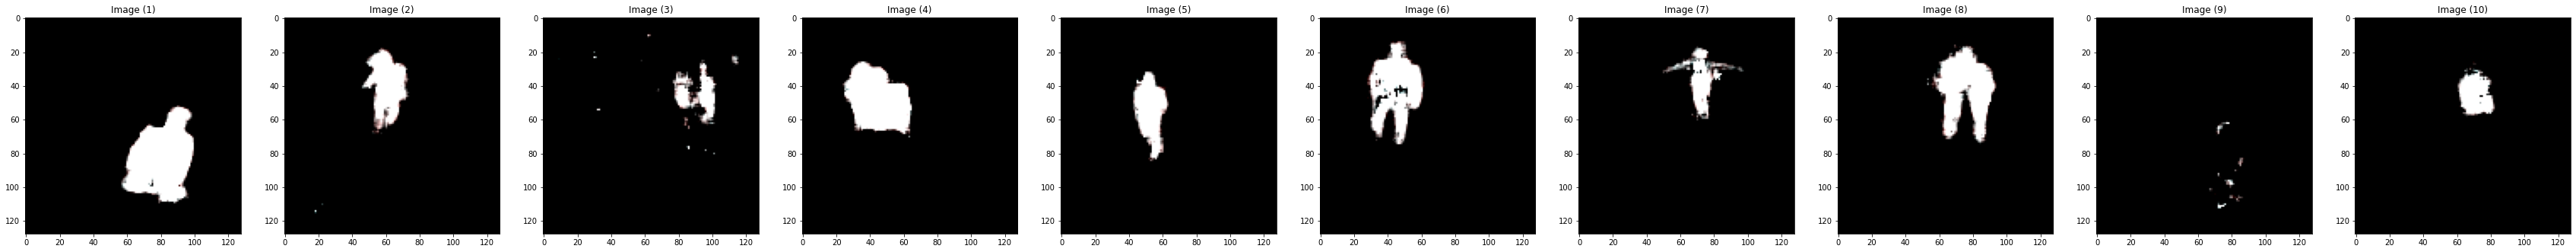

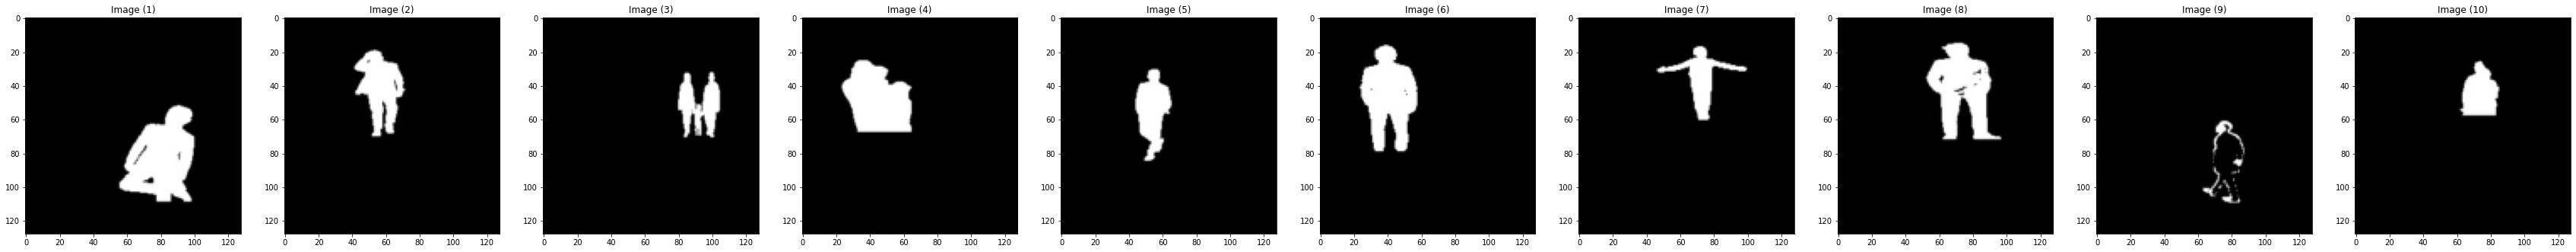

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

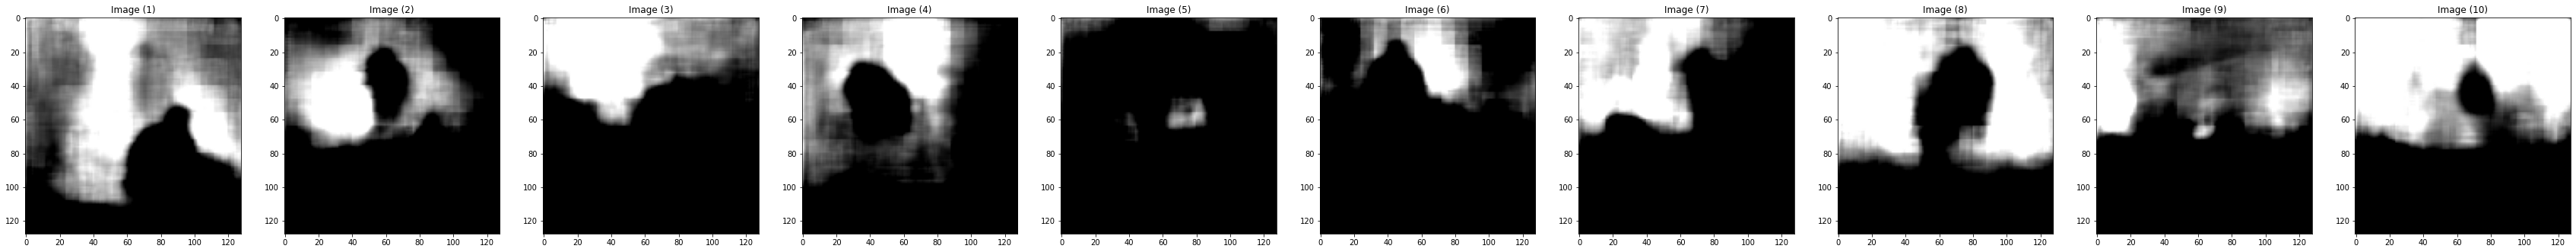

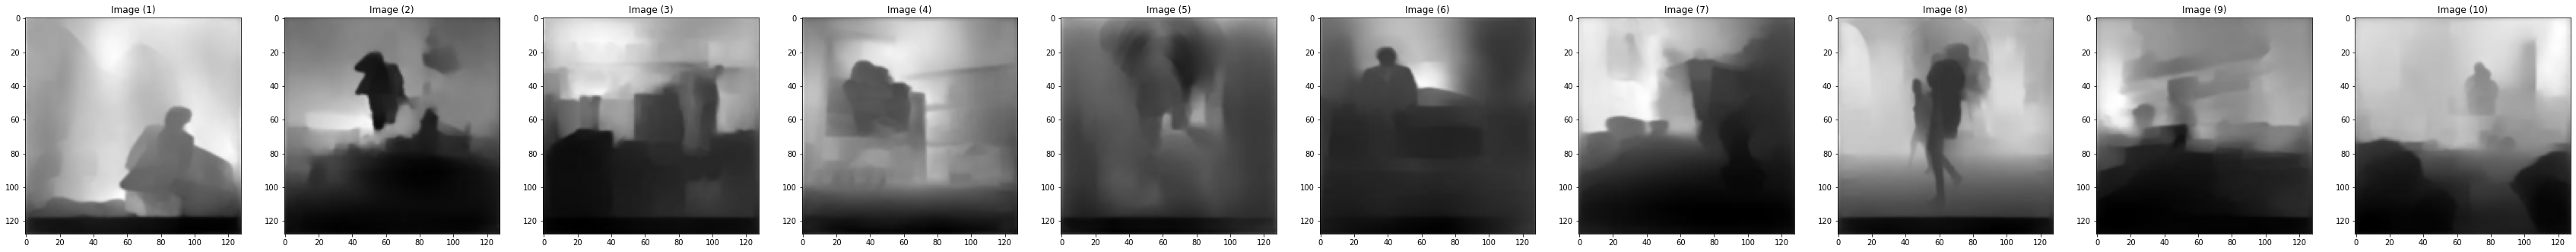

In [25]:
from images import images as im
a,b,c,d=out.shape
images_out=[]
images_in=[]
images_out1=[]
images_in1=[]
for i in range(2,12):
  images_out.append(np.transpose(out[i].cpu().detach().numpy(),(1,2,0)))
  images_in.append(np.transpose(data['mask'][i].cpu().detach().numpy(),(1,2,0)))
  images_out1.append(np.transpose(out1[i].cpu().detach().numpy(),(1,2,0)))
  images_in1.append(np.transpose(data['depth'][i].cpu().detach().numpy(),(1,2,0)))
im.show_images(images_out)
im.show_images(images_in)
im.show_images(images_out1)
im.show_images(images_in1)

In [0]:
torch.save(model.state_dict(),'Depth_128_final.pt')